In [1]:
!pip install 'numpy>=1.20,<1.24'
# verzija nize od 1.24 zbog problema s numpy float

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.29.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.88 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which i

In [4]:
import pandas as pd
import numpy as np
import requests
import json
import xmltodict
from rdkit import Chem
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Učitavanje podataka

In [6]:
path = "/content/drive/My Drive/kemoinf/data/dopamine.csv"
#path = "./data/dopamine.csv"

In [7]:
data = pd.read_csv(path, index_col=0)
data

,ChEMBL_ID,pIC50
0,CHEMBL303519,5.01
1,CHEMBL292943,7.30
2,CHEMBL61682,7.60
3,CHEMBL64487,6.44
4,CHEMBL64597,6.52
...,...,...
474,CHEMBL3805434,7.42
475,CHEMBL3805327,7.23
476,CHEMBL3805262,5.80
477,CHEMBL3805515,6.70


### 2. Dohvaćanje SMILES zapisa

Retrieve SMILES representation for each molecule using the ChEMBL REST API through your Python environment.

Make SMILES canonical by using rdkit Python package.

In [9]:
smiles = []
for mol_id in data.ChEMBL_ID:
    response = requests.get(f'https://www.ebi.ac.uk/chembl/api/data/molecule/{mol_id}')
    smiles.append(Chem.CanonSmiles(xmltodict.parse(response.text)['molecule']['molecule_structures']['canonical_smiles']))
data['smiles'] = smiles
# data.to_csv('./data/temp.csv', index=False)

In [10]:
data

,ChEMBL_ID,pIC50,smiles
0,CHEMBL303519,5.01,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1
1,CHEMBL292943,7.30,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1
2,CHEMBL61682,7.60,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1
3,CHEMBL64487,6.44,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1
4,CHEMBL64597,6.52,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1
...,...,...,...
474,CHEMBL3805434,7.42,CNC(=O)c1cc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)cc(C...
475,CHEMBL3805327,7.23,CNC(=O)c1ccc(Cl)c(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC...
476,CHEMBL3805262,5.80,CNC(=O)c1cc(F)cc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c1
477,CHEMBL3805515,6.70,CNC(=O)c1cccc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c1OC


### 3. Računanje moleklularnih deskriptora
Calculate molecular descriptors by using Mordred Python package or some other available molecular descriptor calculator. Use all available 0D, 1D, 2D and 3D molecular descriptors


- 0D descriptors: Molecular weight, atom count, etc.
- 1D descriptors: Simple structural features
- 2D descriptors: Topological and connectivity-based descriptors
- 3D descriptors: Geometric and spatial characteristics

https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors
import pandas as pd
import tempfile
import os

def generate_3d_conformer(mol):
    """
    Generate 3D conformer for a molecule.
    """
    mol = Chem.AddHs(mol)
    success = AllChem.EmbedMolecule(mol, randomSeed=42, useRandomCoords=True)
    if success == -1:
        return None
    try:
        AllChem.MMFFOptimizeMolecule(mol)
    except:
        try:
            AllChem.UFFOptimizeMolecule(mol)
        except:
            return None
    return mol

def smiles_to_sdf(df, smiles_col='smiles', id_col='ChEMBL_ID'):
    """
    Convert SMILES to SDF file with 3D conformers.
    """
    mols = []
    valid_indices = []

    for idx, row in df.iterrows():
        mol = Chem.MolFromSmiles(row[smiles_col])
        if mol is not None:
            mol_3d = generate_3d_conformer(mol)
            if mol_3d is not None:
                # Add properties to the molecule
                for col in df.columns:
                    if col != smiles_col:
                        mol_3d.SetProp(col, str(row[col]))
                mols.append(mol_3d)
                valid_indices.append(idx)
            else:
                print(f"Failed to generate 3D conformer for molecule {row[id_col]}")

    temp_sdf = tempfile.NamedTemporaryFile(suffix='.sdf', delete=False)
    writer = Chem.SDWriter(temp_sdf.name)

    for mol in mols:
        writer.write(mol)
    writer.close()

    return temp_sdf.name, valid_indices

def calculate_mordred_descriptors(sdf_file):
    """
    Calculate all Mordred descriptors including 3D.
    """
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [mol for mol in Chem.SDMolSupplier(sdf_file) if mol is not None]
    df_descriptors = calc.pandas(mols)
    return df_descriptors

print("Converting SMILES to 3D structures and generating SDF file...")
sdf_file, valid_indices = smiles_to_sdf(df=data)

try:
    print("Calculating descriptors...")
    descriptors_df = calculate_mordred_descriptors(sdf_file)

    # Combine the descriptors with the original data
    valid_data = data.iloc[valid_indices].reset_index(drop=True)
    final_dataset = pd.concat([valid_data.reset_index(drop=True), descriptors_df.reset_index(drop=True)], axis=1)

    # Save the complete dataset
    final_dataset.to_csv('molecular_features.csv', index=False)

    # Print summary statistics
    print("\nDataset Summary:")
    print(f"Total molecules processed: {len(final_dataset)}")
    print(f"Total features generated: {len(final_dataset.columns)}")

finally:
    # Clean up temporary file
    os.remove(sdf_file)

Converting SMILES to 3D structures and generating SDF file...


[13:01:10] UFFTYPER: Unrecognized charge state for atom: 21
[13:01:10] UFFTYPER: Unrecognized charge state for atom: 21


Calculating descriptors...


  3%|▎         | 15/479 [00:05<02:21,  3.28it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 18%|█▊        | 85/479 [00:36<02:27,  2.67it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 479/479 [04:09<00:00,  1.92it/s]



Dataset Summary:
Total molecules processed: 479
Total features generated: 1829


In [12]:
final_dataset.head()

,ChEMBL_ID,pIC50,smiles,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CHEMBL303519,5.01,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,21.011003,14.920944,0,1,35.835568,2.504877,4.869002,...,10.266776,75.682997,342.184447,7.128843,1797,42,144.0,173.0,5.388889,5.638889
1,CHEMBL292943,7.30,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,21.132323,14.720991,0,1,36.522379,2.360154,4.720308,...,10.083765,61.954496,360.195011,7.062647,2172,40,140.0,162.0,6.527778,6.055556
2,CHEMBL61682,7.60,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,21.310663,15.088212,0,1,35.81174,2.370165,4.74033,...,10.141362,62.103563,365.170354,7.607716,2130,41,142.0,165.0,7.138889,5.916667
3,CHEMBL64487,6.44,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,21.091883,15.171089,0,1,36.528506,2.378509,4.757019,...,10.117429,62.012532,360.195011,7.062647,2096,41,140.0,163.0,6.527778,6.083333
4,CHEMBL64597,6.52,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,19.011003,14.059124,0,1,32.579628,2.356613,4.698085,...,9.949655,71.503368,336.140868,7.639565,1532,33,126.0,146.0,5.166667,5.305556


### 4. Čišćenje podataka
Clean the transformed data of missing values and outliers. Remove duplicates.

- Nema duplikata.
- After generating all descriptors for each molecule, we removed descriptors with non-numerical values (e.g., containing strings or NA values) and descriptors with matching values across most (
95%) molecules. (https://www.sciencedirect.com/science/article/pii/S0016236122006950#sec3)

In [13]:
from sklearn.feature_selection import VarianceThreshold

def prepare_features(descriptors_df):
    """
    Clean and prepare descriptors for machine learning while preserving specified columns.
    Applies VarianceThreshold for low-variance feature selection.
    """
    # Columns to preserve
    string_columns_to_preserve = ['ChEMBL_ID', 'smiles', 'pIC50']

    # Separate preserved columns
    preserved_columns = descriptors_df[string_columns_to_preserve]

    # Work on the remaining numeric columns
    numeric_df = descriptors_df.drop(columns=string_columns_to_preserve, errors='ignore')

    # Convert all to numeric, replacing non-numeric with NaN
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with any NaN values
    numeric_df = numeric_df.dropna(axis=1)

    # Apply VarianceThreshold for low-variance feature selection
    selection = VarianceThreshold(threshold=(.8 * (1 - .8)))  # Threshold = 0.16 (80% * (1-80%))
    numeric_df_array = selection.fit_transform(numeric_df)  # Transform to array

    # Convert back to DataFrame, retaining column names post-selection
    selected_columns = numeric_df.columns[selection.get_support()]
    numeric_df = pd.DataFrame(numeric_df_array, columns=selected_columns)

    # Combine preserved columns back with cleaned numeric data
    final_df = pd.concat([preserved_columns.reset_index(drop=True), numeric_df.reset_index(drop=True)], axis=1)

    return final_df


In [14]:
final_dataset = prepare_features(final_dataset)
final_dataset['smiles'].duplicated().sum()

0

In [15]:
null_counts = final_dataset.isnull().sum()
columns_with_nulls = null_counts[null_counts != 0]
print(columns_with_nulls)

Series([], dtype: int64)


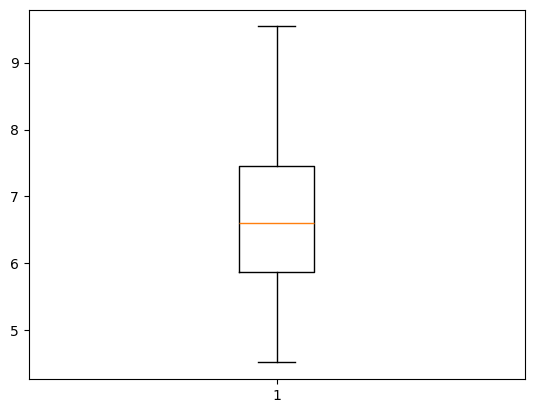

In [16]:
# boxplot značajke koju bismo trebali predvidjeti
# nema outliera
plt.boxplot(final_dataset['pIC50'])
plt.show()

In [17]:
final_dataset['pIC50'].describe()

,pIC50
count,479.000000
mean,6.698689
std,1.070454
min,4.520000
25%,5.865000
50%,6.600000
75%,7.450000
max,9.540000


In [18]:
final_dataset.shape

(479, 566)

### 5. Feature analysis

https://www.sciencedirect.com/science/article/pii/S0016236122006950?ref=pdf_download&fr=RR-2&rr=8fdc0950fb31ec1e
https://iopscience.iop.org/article/10.1088/1742-6596/2219/1/012046/pdf

**Simple correlation analysis with pIC50 feature**

In [ ]:
# # Columns to preserve
# preserved_columns = ['ChEMBL_ID', 'smiles', 'pIC50']

# # Identify columns to compute correlations for
# numeric_columns = [col for col in final_dataset.columns if col not in preserved_columns]

# # Create a feature correlation matrix with pIC50
# correlations = pd.DataFrame({
#     'feature': numeric_columns,
#     'correlation_with_pIC50': [
#         final_dataset[col].corr(final_dataset['pIC50']) for col in numeric_columns
#     ]
# })

# # Sort correlations by absolute value
# correlations = correlations.sort_values('correlation_with_pIC50', key=abs, ascending=False)

# # Display the top 20 most correlated features
# print("\nTop 20 most correlated features with pIC50:")
# print(correlations.head(20))

**Recursive Feature Elimination (RFE) with an ensemble model estimator (Random Forest Regressor)**

In [21]:
X = final_dataset.drop(['pIC50', 'ChEMBL_ID', 'smiles'], axis=1)
y = final_dataset['pIC50']

In [ ]:
#print(X.shape)
#correlation_matrix = X.corr(method='spearman')

#upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

 # Find features with correlation > 0.85
#high_correlation_features = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop highly correlated features
#filtered_dataset = X.drop(columns=high_correlation_features)
#print(filtered_dataset.shape)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np


def efficient_feature_selection(X: pd.DataFrame,
                                y: pd.Series,
                                min_features: int = 20,
                                max_features: int = 30,
                                random_state: int = 42):
    """
    Efficient feature selection using a two-step approach:
    1. Remove autocorrelation descriptors
    2. Initial feature reduction using RandomForest importance
    3. Fine-tuning using RFECV with reduced feature set
    4. Post-processing to remove one of two highly correlated features.

    Args:
        X: Feature DataFrame
        y: Target Series
        min_features: Minimum number of features to select
        max_features: Maximum number of features for initial filtering
        random_state: Random seed for reproducibility

    Returns:
        Tuple of (selected features DataFrame, list of feature names)
    """
    # Step 0: Remove autocorrelation descriptors
    autocorr_keywords = ["ATSC", "AATS"]  # Keywords to identify autocorrelation descriptors
    autocorr_features = [
        col for col in X.columns if any(keyword in col for keyword in autocorr_keywords)
    ]
    X = X.drop(columns=autocorr_features)

    print(f"Removed {len(autocorr_features)} autocorrelation descriptors.")

    # Step 1: Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Step 2: Initial feature reduction using RandomForest importance
    pre_selector = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        n_jobs=-1,
        random_state=random_state
    )

    pre_selector.fit(X_scaled, y)

    # Get feature importance and select top features
    importances = pd.Series(pre_selector.feature_importances_, index=X.columns)
    importances_sorted = importances.sort_values(ascending=False)

    # Select top features (max_features or 2 * target_features, whichever is smaller)
    n_features_to_keep = min(max_features, len(importances_sorted))
    top_features = importances_sorted.head(n_features_to_keep).index.tolist()

    # Step 3: Filter to top features
    X_reduced = X_scaled[top_features]

    # Step 4: Post-processing - Remove highly correlated features
    # Calculate Pearson correlation
    corr_matrix = X_reduced.corr(method='pearson').abs()
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1)
    upper_corr_matrix = pd.DataFrame(corr_matrix.values * upper_triangle,
                                     columns=corr_matrix.columns,
                                     index=corr_matrix.index)

    # Identify pairs of highly correlated features
    high_corr_pairs = [(col1, col2)
                       for col1 in upper_corr_matrix.columns
                       for col2 in upper_corr_matrix.index
                       if upper_corr_matrix.loc[col2, col1] > 0.9]  # Threshold for correlation

    # Remove the feature with the smaller importance from each pair
    features_to_remove = set()
    for feat1, feat2 in high_corr_pairs:
        if feat1 in importances and feat2 in importances:
            # Compare importance and remove the less important feature
            if importances[feat1] > importances[feat2]:
                features_to_remove.add(feat2)
            else:
                features_to_remove.add(feat1)

    # Remove highly correlated features
    X_reduced = X_reduced.drop(columns=list(features_to_remove))
    top_features = [feat for feat in top_features if feat not in features_to_remove]

    # Step 5: RFECV on reduced feature set
    rf_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=random_state
    )

    rfecv = RFECV(
        estimator=rf_model,
        step=1,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        min_features_to_select=min_features,
        verbose=0
    )

    rfecv.fit(X_reduced, y)

    # Get final selected features
    final_features = X_reduced.columns[rfecv.support_].tolist()

    # Calculate final feature importance
    final_importance = pd.Series(
        rfecv.estimator_.feature_importances_,
        index=final_features
    ).sort_values(ascending=False)

    return X[final_features], final_features


X_selected, selected_features = efficient_feature_selection(
    X=X,
    y=y,
    min_features=20,
    max_features=30
)

Removed 156 autocorrelation descriptors.


In [23]:
X_selected.shape

(479, 25)

In [24]:
selected_features

['VSA_EState4',
 'SlogP_VSA3',
 'PNSA1',
 'n5AHRing',
 'PEOE_VSA13',
 'VSA_EState8',
 'piPC10',
 'GGI5',
 'PNSA2',
 'SaaCH',
 'BalabanJ',
 'SlogP_VSA10',
 'FilterItLogS',
 'n6AHRing',
 'PEOE_VSA9',
 'RNCS',
 'SsssN',
 'ZMIC2',
 'Xpc-5dv',
 'PEOE_VSA2',
 'MDEC-33',
 'VSA_EState7',
 'PEOE_VSA7',
 'SRW09',
 'SsCH3']

In [29]:
# Extract the ChEMBL_ID and smiles columns
chembl_smiles = final_dataset[['ChEMBL_ID', 'smiles']]

# Combine X_selected, chembl_smiles, and y into a single DataFrame
rfe_dataset = pd.concat([chembl_smiles.reset_index(drop=True), X_selected.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

# Display the first few rows of the final dataset
rfe_dataset.head()

,ChEMBL_ID,smiles,VSA_EState4,SlogP_VSA3,PNSA1,n5AHRing,PEOE_VSA13,VSA_EState8,piPC10,GGI5,...,SsssN,ZMIC2,Xpc-5dv,PEOE_VSA2,MDEC-33,VSA_EState7,PEOE_VSA7,SRW09,SsCH3,pIC50
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,7.288376,12.965578,342.075567,0.0,0.0,5.100114,7.484263,0.524444,...,4.833147,31.601003,2.632137,4.899910,5.451870,4.707134,40.304446,7.065613,0.000000,5.01
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,3.794351,6.544756,300.030862,0.0,0.0,4.924489,7.100949,0.687500,...,4.746878,30.780458,1.782437,4.899910,2.317315,3.609869,40.955823,0.000000,1.693745,7.30
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,3.736949,6.544756,375.878666,0.0,0.0,4.134322,7.054686,0.652778,...,4.446251,32.962532,1.931053,9.883888,3.103576,3.669760,41.458738,0.000000,0.000000,7.60
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,3.649986,6.544756,299.129737,0.0,0.0,4.882123,7.004265,0.659722,...,4.738625,32.242227,1.910653,4.899910,2.939866,3.607263,29.326004,0.000000,1.720852,6.44
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,4.000998,6.544756,313.868717,0.0,0.0,5.047420,6.652319,0.444444,...,4.768305,28.479441,1.836235,4.899910,1.618870,3.620325,45.649581,6.293419,0.000000,6.52


In [35]:
rfe_dataset.to_csv('rfe_dataset.csv', index=False)

### 6. Skaliranje podatka

Define and initialize scaler by using Scikit-learn Python package. Scale the data appropriately.

- https://scikit-learn.org/1.5/modules/preprocessing.html -> trebalo bi proučiti i odabrati scaler na temelju značajki (?)

In [ ]:
#final_dataset.describe()

In [ ]:
#from sklearn import preprocessing

#scaled_df = final_dataset.copy()

#scaler = preprocessing.MinMaxScaler()
#for col in scaled_df:
 #   if pd.api.types.is_numeric_dtype(scaled_df[col]):
  #      scaled_df[col] = scaler.fit_transform(np.array(scaled_df[col]).reshape(-1, 1))
#
#scaled_df.describe()
#final_dataset = scaled_df.copy()

### 6. Splitting
Split the preprocessed dataset into subset for training and subset for testing in ratio 75:25. If using deep learning, split into subset for validation as well (ratio 70:15:15)

In [20]:
train, test = train_test_split(final_dataset, test_size=0.25, random_state=42)

train_DL, test_DL = train_test_split(final_dataset, test_size=0.3, random_state=42)
validate_DL, test_DL = train_test_split(test_DL, test_size=0.5, random_state=42)

train.to_pickle("./data/train.pkl")
test.to_pickle("./data/test.pkl")
train_DL.to_pickle("./data/train_DL.pkl")
test_DL.to_pickle("./data/test_DL.pkl")
validate_DL.to_pickle("./data/validate_DL.pkl")

In [34]:
train, test = train_test_split(rfe_dataset, test_size=0.25, random_state=42)

train_DL, test_DL = train_test_split(rfe_dataset, test_size=0.3, random_state=42)
validate_DL, test_DL = train_test_split(test_DL, test_size=0.5, random_state=42)

train.to_pickle("./data/train_rfe.pkl")
test.to_pickle("./data/test_rfe.pkl")
train_DL.to_pickle("./data/train_DL_rfe.pkl")
test_DL.to_pickle("./data/test_DL_rfe.pkl")
validate_DL.to_pickle("./data/validate_DL_rfe.pkl")